# ADVANTAGES OF PORTABLE-ALPHA STRUCTURES

## `import`s

In [17]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

import foggy_statslib.core as fc

## What is portable alpha?

Say our universe consists of three stocks, A, B, and C, with A twice as large and half as volatile as B or C. Don't worry about the math setup in this part, the details are not important.

In [26]:
MKT_CAP: Final[pd.Series] = pd.Series({"A": 1_000, "B": 500, "C": 500})
BMK: Final[pd.Series] = MKT_CAP / MKT_CAP.sum()
VOL: Final[pd.Series] = pd.Series({"A": 0.10, "B": 0.20, "C": 0.20})
CORR: Finall[pd.DataFrame] = pd.DataFrame(
    {
        "A": {"A": 1, "B": 0.50, "C": 0.50},
        "B": {"A": 0.50, "B": 1, "C": 0.90},
        "C": {"A": 0.50, "B": 0.90, "C": 1},
    }
)
COV: Final[pd.DataFrame] = (
    pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
    @ CORR
    @ pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
)

def _get_pflio_cov(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    return w_a @ COV @ w_b

def _get_pflio_vol(w: pd.Series = BMK) -> float:
    return _get_pflio_cov(w, w)**0.5

def _get_pflio_corr(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    cov = _get_pflio_cov(w_a=w_a, w_b=w_b)
    vol_a = _get_pflio_vol(w=w_a)
    vol_b = _get_pflio_vol(w=w_b)
    return cov / (vol_a * vol_b)

Think of two funds investing in this market:
* An index-tracking mutual fund, and
* A traditional long-only stock-picking hedge fund (I already cringe at this name... how can you be long-only and also hedged... the whole point of a hedge fund used to be uncorrelated absolute returns...).

They might have holdings something like this:

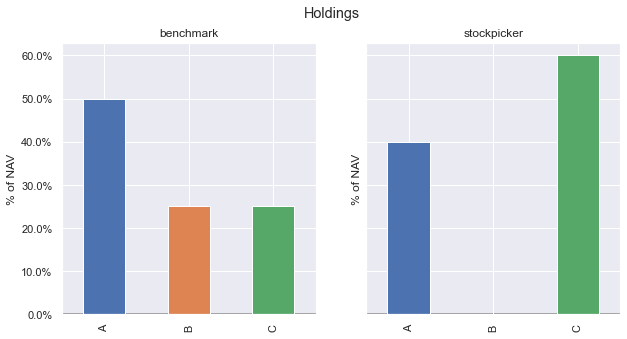

In [12]:
holdings = pd.DataFrame(
    {
        "benchmark": {"A": 0.50, "B": 0.25, "C": 0.25},
        "stockpicker": {"A": 0.40, "B": 0, "C": 0.60},
    }
)

_, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
for (i, (f, h)) in enumerate(holdings.items()):
    fc.plot(
        h,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        ylabel="% of NAV",
        title=f,
        ax=ax[i],
        figsize=(10, 5),
    )
plt.suptitle("Holdings")
plt.show()

Now, let's decompose the stockpicker's holdings into two "parts":
* A beta part, and
* An alpha part.